In [29]:
import tensorflow as tf
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [30]:
#Loading and creating subset of class
import pickle
import numpy as np

train_path = '/kaggle/input/cifar100/train'
test_path = '/kaggle/input/cifar100/test'

with open(train_path, 'rb') as f:
    train = pickle.load(f, encoding = 'bytes')
    
with open(test_path, 'rb') as f:
    test = pickle.load(f, encoding = 'bytes')
    
#dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])
def extract_data_for_n_classes(images, labels, n_classes):
    new_images, new_labels = [], []
    for image, label in zip(images, labels):
        if label < n_classes - 1:
            new_images.append(image)
            new_labels.append(label)
    
    return np.array(new_images), np.array(new_labels)

N_CLASSES = 100 #Started with 25 to train models quicker
train_images = train[b'data'].reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)
test_images = test[b'data'].reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)
train_x, train_y = extract_data_for_n_classes(train_images, train[b'fine_labels'], N_CLASSES)
test_x, test_y = extract_data_for_n_classes(test_images, test[b'fine_labels'], N_CLASSES)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((49500, 32, 32, 3), (49500,), (9900, 32, 32, 3), (9900,))

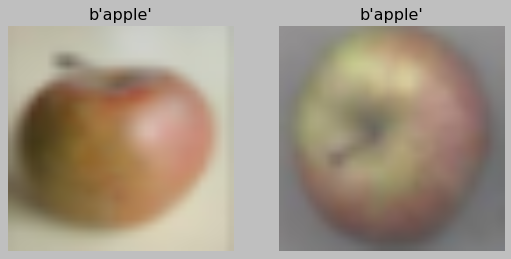

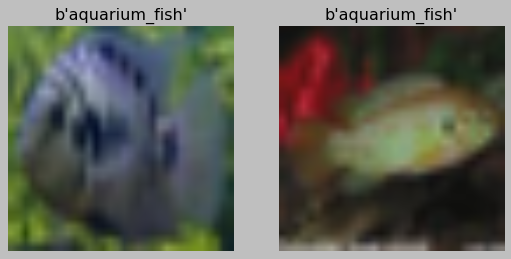

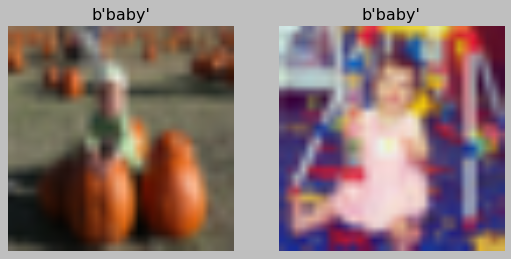

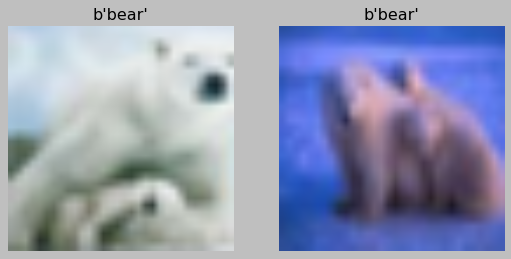

In [31]:
#Method for displaying images and viewing image classes
import matplotlib.pyplot as plt
plt.style.use("classic")

with open('/kaggle/input/cifar100/meta', 'rb') as f:
    meta = pickle.load(f, encoding = 'bytes')

key = meta[b'fine_label_names']

def print_entries_of_each_class(n_entries, n_classes):
    for class_idx in range(n_classes - 1):
        plt.figure()
        class_name = key[class_idx]
        class_images = [img for img, label in zip(train_x, train_y) if label == class_idx]
        for img_idx in range(n_entries):
            plt.subplot(1, n_entries, img_idx + 1)
            plt.imshow(class_images[np.random.randint(0, len(class_images) - 1)])
            plt.title(class_name)
            plt.axis("off")
        plt.show()
        
print_entries_of_each_class(2, 5)

In [32]:
#Preprocessing
import cv2

if 'original_train_x' not in locals():
    original_train_x = train_x
    original_test_x = test_x

IMG_SHAPE = 32
    
def preprocess(img):
    img = img * 1.15
    edges = cv2.Sobel(src = img, ddepth = cv2.CV_64F, dx = 1, dy = 1, ksize = 3) #Sobel edges
    #edges = cv2.Canny(img, 0.1, 0.5, 3, True) #Canny edges
    img = cv2.addWeighted(img, 1, edges, 1.1, 0) #Enhancing edges
    img = cv2.resize(img, (IMG_SHAPE, IMG_SHAPE)) #For more convolutions
    img = img / 255
    return img
    
train_x = [preprocess(img) for img in original_train_x]
test_x = [preprocess(img) for img in original_test_x]
print(len(train_x), len(train_y))


#print_entries_of_each_class(2, 5)

train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

49500 49500


((49500, 32, 32, 3), (49500,), (9900, 32, 32, 3), (9900,))

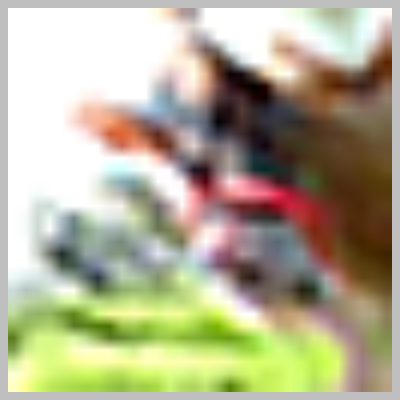

In [33]:
#Data augmentation to use with both layers

data_aug = tf.keras.models.Sequential([
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomFlip(0.1),
    tf.keras.layers.RandomRotation(0.1)
])

aug_x = data_aug(train_x)
plt.imshow(aug_x[0])
plt.axis('off')
plt.show()

Epoch 1/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.0301 - loss: 4.3594 - val_accuracy: 0.0774 - val_loss: 3.9440 - learning_rate: 0.0010
Epoch 2/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.0918 - loss: 3.8808 - val_accuracy: 0.1206 - val_loss: 3.6838 - learning_rate: 0.0010
Epoch 3/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.1211 - loss: 3.6865 - val_accuracy: 0.1364 - val_loss: 3.6920 - learning_rate: 0.0010
Epoch 4/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.1518 - loss: 3.5213 - val_accuracy: 0.1564 - val_loss: 3.5671 - learning_rate: 0.0010
Epoch 5/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.1743 - loss: 3.3968 - val_accuracy: 0.1693 - val_loss: 3.4460 - learning_rate: 0.0010
Epoch 6/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.1968 - loss: 3.2944 - val_accuracy: 0.1772 - val_loss: 3.3932 - learning_rate: 0.0010
Epoch 7/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.2

<Axes: title={'center': 'loss'}>

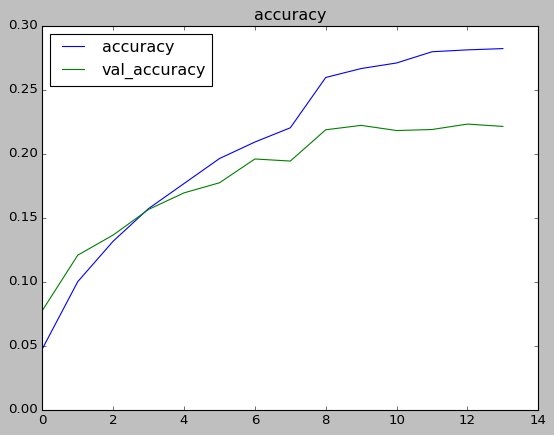

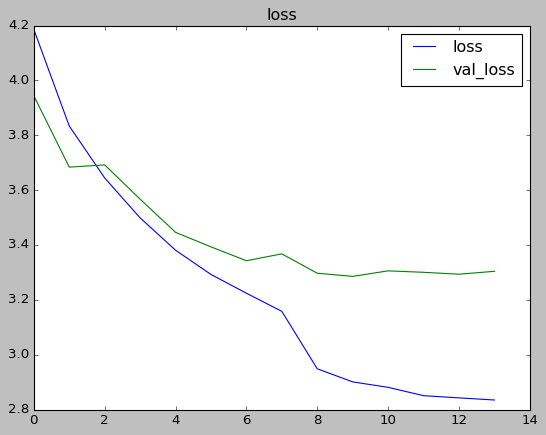

In [34]:
#CNN to evaluate compared to a vision transformer
import pandas as pd
from sklearn.metrics import classification_report

cnn = tf.keras.models.Sequential([
    tf.keras.layers.Input((IMG_SHAPE, IMG_SHAPE, 3)),
    data_aug,
    tf.keras.layers.Conv2D(64, 3, activation = 'relu'),
    tf.keras.layers.Conv2D(64, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, activation = 'relu'),
    tf.keras.layers.Conv2D(128, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, activation = 'relu'),
    tf.keras.layers.Conv2D(128, 3, activation = 'relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(N_CLASSES, activation = 'softmax')
])

cnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

val_split = 9 * (len(train_x) // 10)
val_x, val_y = train_x[val_split:], train_y[val_split:]
train_x, train_y = train_x[:val_split], train_y[:val_split]
aug_x = data_aug(train_x)

cnn_hist = cnn.fit(aug_x, train_y, epochs = 20, validation_data = [val_x, val_y], callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 0.02, patience = 5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', min_delta = 0.02, patience = 2)
]).history

cnn_hist = pd.DataFrame(cnn_hist)
cnn_hist[['accuracy', 'val_accuracy']].plot(title = 'accuracy')
cnn_hist[['loss', 'val_loss']].plot(title = 'loss')

In [35]:
#Timing inference and showing classificiaton report of results
import time

start = time.time()
preds = cnn.predict(test_x)
ytrue = [key[i] for i in test_y]
preds = [key[np.argmax(i)] for i in preds]
end = time.time()

print(f"Prediction time: {end - start}")
print(classification_report(ytrue, preds))

310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Prediction time: 1.0658020973205566
                  precision    recall  f1-score   support

        b'apple'       0.71      0.55      0.62       100
b'aquarium_fish'       0.39      0.26      0.31       100
         b'baby'       0.23      0.13      0.17       100
         b'bear'       0.17      0.05      0.08       100
       b'beaver'       0.12      0.07      0.09       100
          b'bed'       0.19      0.08      0.11       100
          b'bee'       0.23      0.25      0.24       100
       b'beetle'       0.24      0.24      0.24       100
      b'bicycle'       0.08      0.22      0.12       100
       b'bottle'       0.43      0.28      0.34       100
         b'bowl'       0.33      0.02      0.04       100
          b'boy'       0.09      0.05      0.07       100
       b'bridge'       0.26      0.22      0.24       100
          b'bus'       0.09      0.21      0.13       100
    b'butterfly'       0.14      0.20      0.17     

In [36]:
### Default VIT encoding layer as used in 

class DefaultEncoding(tf.keras.Layer):
    def __init__(self, img_size, patch_size, embedding_size, n):
        super(DefaultEncoding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = int(img_size * img_size / (patch_size * patch_size))
        self.dense = tf.keras.layers.Dense(embedding_size)
        self.add = tf.keras.layers.Add()
        self.embedding_size = embedding_size
        self.batch_size = None
        self.prepend_embedding = tf.random.normal(shape = (1, 1, self.embedding_size))
        
        self.positional_embeddings = []
        self.n = n
        
        for k in range(1, self.n_patches + 2):
            k_embedding = []
            for i in range(1, embedding_size + 1):
                if(i % 2 == 0):
                    k_embedding.append(np.sin(k / np.power(self.n, 2 * i / embedding_size)))
                else:
                    k_embedding.append(np.cos(k / np.power(self.n, 2 * i / embedding_size)))
            self.positional_embeddings.append(k_embedding)
            
        self.positional_embeddings = np.array(self.positional_embeddings)
    
    
    def build(self, input_shape):
        super(DefaultEncoding, self).build(input_shape)
        self.prepend_embedding = self.add_weight(shape = self.prepend_embedding.shape)
      
    def call(self, inputs):
        self.batch_size = tf.shape(inputs)[0]
        patches = tf.image.extract_patches(inputs, sizes = (1, self.patch_size, self.patch_size, 1),
                                                    strides = (1, self.patch_size, self.patch_size, 1),
                                                    rates = (1, 1, 1, 1),
                                                    padding = "SAME")
        patches = tf.reshape(patches, (self.batch_size, -1, self.patch_size, self.patch_size, 3))
        patches_flattened = tf.reshape(patches, (self.batch_size, self.n_patches, 
                                                 self.patch_size * self.patch_size * 3))
        
        embeddings = self.dense(patches_flattened)
        prepend_embedding = tf.tile(self.prepend_embedding, (self.batch_size, 1, 1))
        prepended_embeddings = tf.concat([embeddings, prepend_embedding], axis = 1)
        
        positional_encodings = tf.cast(prepended_embeddings, tf.float32) + self.positional_embeddings
        return positional_encodings
        
        
        
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.n_patches + 1, self.embedding_size)

    
    #This is how it's defined in the paper "An Image is Worth 16x16 Words" However it performs a little better without the prepended encoding, possibly because of how arbitrary it is

In [37]:
#Attention block layer

class AttentionBlock(tf.keras.Layer):
    def __init__(self, n_heads, dim): #dim = embedding size
        super(AttentionBlock, self).__init__()
        self.attention = tf.keras.layers.MultiHeadAttention(n_heads, dim, dim)
        self.dense = tf.keras.layers.Dense(dim, activation = 'relu')
        self.add = tf.keras.layers.Add()
        self.norm = tf.keras.layers.LayerNormalization()
        
    def call(self, inputs):
        attention = self.attention(query = inputs, key = inputs, value = inputs)
        add_norm = self.norm(self.add([inputs, attention]))
        ff = self.dense(add_norm)
        add_norm_2 = self.norm(self.add([ff, add_norm]))
        return add_norm_2
    

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ default_encoding_2              │ (None, 17, 128)        │           128 │
│ (DefaultEncoding)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_block_8               │ (None, 17, 128)        │       544,256 │
│ (AttentionBlock)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 2176)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │     1,114,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 100)            │        51,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,710,308 (6.52 MB)

 Trainable params: 1,710,308 (6.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
  33/1393 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.0143 - loss: 5.5593

W0000 00:00:1724005427.145440     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1393/1393 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0102 - loss: 4.6689

W0000 00:00:1724005433.938444     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724005435.009098     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1393/1393 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.0102 - loss: 4.6689 - val_accuracy: 0.0071 - val_loss: 4.6000 - learning_rate: 0.0010
Epoch 2/30
  34/1393 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.0131 - loss: 4.5989  

W0000 00:00:1724005436.095720     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0092 - loss: 4.5985 - val_accuracy: 0.0071 - val_loss: 4.5989 - learning_rate: 0.0010
Epoch 3/30
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0093 - loss: 4.5968 - val_accuracy: 0.0071 - val_loss: 4.5982 - learning_rate: 0.0010
Epoch 4/30
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0097 - loss: 4.5962 - val_accuracy: 0.0079 - val_loss: 4.5981 - learning_rate: 0.0010
Epoch 5/30
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0095 - loss: 4.5958 - val_accuracy: 0.0077 - val_loss: 4.5979 - learning_rate: 0.0010
Epoch 6/30
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0097 - loss: 4.5957 - val_accuracy: 0.0081 - val_loss: 4.5979 - learning_rate: 0.0010
Epoch 7/30
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0106 - loss: 4.5951 - val_accuracy: 0.0081 - val_loss: 4.5979 - learning_rate: 1.0000e-04
Epoch 8/30
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0108 - loss: 4.

W0000 00:00:1724005486.439121     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


W0000 00:00:1724005487.616832     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Prediction time: 2.1723148822784424
                  precision    recall  f1-score   support

        b'apple'       0.00      0.00      0.00       100
b'aquarium_fish'       0.00      0.00      0.00       100
         b'baby'       0.00      0.00      0.00       100
         b'bear'       0.00      0.00      0.00       100
       b'beaver'       0.00      0.00      0.00       100
          b'bed'       0.00      0.00      0.00       100
          b'bee'       0.00      0.00      0.00       100
       b'beetle'       0.00      0.00      0.00       100
      b'bicycle'       0.00      0.00      0.00       100
       b'bottle'       0.00      0.00      0.00       100
         b'bowl'       0.00      0.00      0.00       100
          b'boy'       0.00      0.00      0.00       100
       b'bridge'       0.00      0.00      0.00       100
          b'bus'       0.00      0.00      0.00       100
    b'butterfly'       0.01      1.00      0.02       100
        b'camel'       0.00      0.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


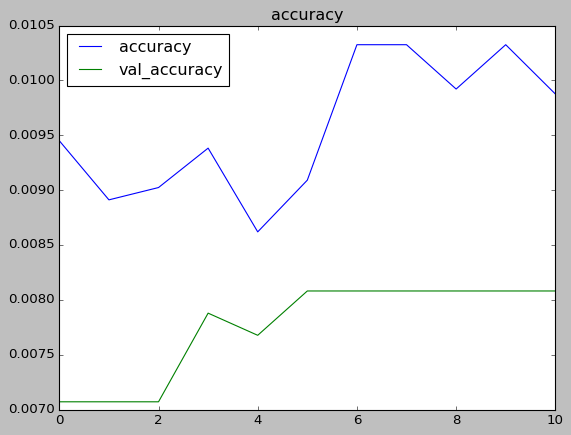

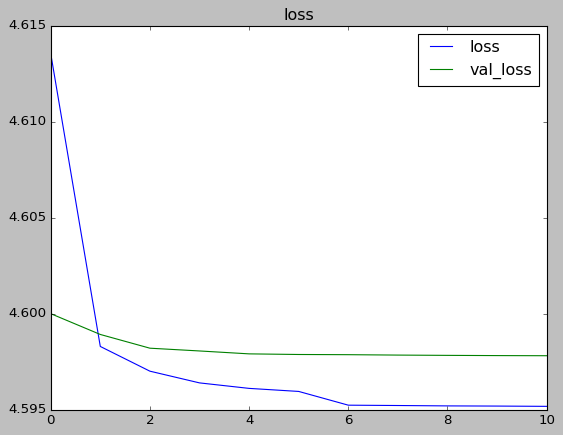

In [38]:
#Creating and training the base vision transformer

embedding_size = 128

vit = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (IMG_SHAPE, IMG_SHAPE, 3)),
    DefaultEncoding(IMG_SHAPE, IMG_SHAPE // 4,embedding_size, 10000),
    AttentionBlock(8, embedding_size),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(N_CLASSES, activation = 'softmax')
])

vit.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
vit.summary()

aug_x = data_aug(train_x)

#For future
def train(model):
    model_hist = model.fit(aug_x, train_y, epochs = 30, validation_data = [val_x, val_y], callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 0.02, patience = 10),
        tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', min_delta = 0.02, patience = 5)
    ], batch_size = 32).history

    model_hist = pd.DataFrame(model_hist)
    model_hist[['accuracy', 'val_accuracy']].plot(title = 'accuracy')
    model_hist[['loss', 'val_loss']].plot(title = 'loss')


    start = time.time()
    preds = model.predict(test_x)
    ytrue = [key[i] for i in test_y]
    preds = [key[np.argmax(i)] for i in preds]
    end = time.time()

    print(f"Prediction time: {end - start}")
    print(classification_report(ytrue, preds))
    
    
train(vit)

In [39]:
#Using attention on convolutions instead of patches

#Default VIT encoding layer as used in 

class ConvEncoding(tf.keras.Layer):
    def __init__(self, img_size, kernel_size, n_filters, embedding_size, n):
        super(ConvEncoding, self).__init__()
        self.img_size = img_size
        self.conv = tf.keras.layers.Conv2D(n_filters, kernel_size, activation = 'relu')
        self.size_after_conv = img_size + 1 - kernel_size
        self.dense = tf.keras.layers.Dense(embedding_size)
        self.add = tf.keras.layers.Add()
        self.embedding_size = embedding_size
        self.n_filters = n_filters
        self.batch_size = None
        
        self.positional_embeddings = []
        self.n = n
        
        for k in range(1, n_filters + 1):
            k_embedding = []
            for i in range(1, embedding_size + 1):
                if(i % 2 == 0):
                    k_embedding.append(np.sin(k / np.power(self.n, 2 * i / embedding_size)))
                else:
                    k_embedding.append(np.cos(k / np.power(self.n, 2 * i / embedding_size)))
            self.positional_embeddings.append(k_embedding)
            
        self.positional_embeddings = np.array(self.positional_embeddings)
        

           
    
    
    def build(self, input_shape):
        super(ConvEncoding, self).build(input_shape)
      
    def call(self, inputs):
        self.batch_size = tf.shape(inputs)[0]
        conv = self.conv(inputs)
        conv = tf.reshape(tf.transpose(conv, (0, 3, 1, 2)), (self.batch_size, conv.shape[-1],
                                                            conv.shape[1] * conv.shape[1]))
        embeddings = self.dense(conv)
        positional_encodings = embeddings + self.positional_embeddings
        return positional_encodings
        
        
        
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.n_filters, self.embedding_size)


In [ ]:
#Training this

vit_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (IMG_SHAPE, IMG_SHAPE, 3)),
    ConvEncoding(IMG_SHAPE, 3, 64, embedding_size, 10000),
    AttentionBlock(8, embedding_size),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(N_CLASSES, activation = 'softmax')
])

vit_cnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
vit_cnn.summary()

train(vit_cnn)

#Overfits a lot less even with another conv layer to make patches
#Might be because I removed the starting prepended embedding, so it has less of an arbitrary weight to train

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_encoding_2 (ConvEncoding)  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_block_9               │ (None, 64, 128)        │       544,256 │
│ (AttentionBlock)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 100)            │       819,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,363,556 (5.20 MB)

 Trainable params: 1,363,556 (5.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
  18/1393 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.0025 - loss: 10.2379  

W0000 00:00:1724005492.709938     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1393/1393 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0386 - loss: 5.2700

W0000 00:00:1724005503.702154     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724005504.509548     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1393/1393 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.0386 - loss: 5.2694 - val_accuracy: 0.1360 - val_loss: 3.6812 - learning_rate: 0.0010
Epoch 2/30
  17/1393 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.1334 - loss: 3.6853

W0000 00:00:1724005505.452268     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1393/1393 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1535 - loss: 3.5701 - val_accuracy: 0.1802 - val_loss: 3.4408 - learning_rate: 0.0010
Epoch 3/30
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1801 - loss: 3.4230 - val_accuracy: 0.1869 - val_loss: 3.4287 - learning_rate: 0.0010
Epoch 4/30
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1806 - loss: 3.4238 - val_accuracy: 0.1564 - val_loss: 3.6149 - learning_rate: 0.0010
Epoch 5/30
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1634 - loss: 3.5416 - val_accuracy: 0.1671 - val_loss: 3.5524 - learning_rate: 0.0010
Epoch 6/30
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1669 - loss: 3.5112 - val_accuracy: 0.1788 - val_loss: 3.4709 - learning_rate: 0.0010
Epoch 7/30
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1703 - loss: 3.4880 - val_accuracy: 0.1889 - val_loss: 3.4073 - learning_rate: 0.0010
Epoch 8/30
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.2111 - loss:

In [ ]:
#Trying CvT https://arxiv.org/pdf/2103.15808

class CVTBlock(tf.keras.Layer):
    def __init__(self, img_size, token_filter_size, projection_filter_size, n_heads):
        super(CVTBlock, self).__init__()
        self.conv_token_embedding = tf.keras.layers.Conv2D(3, token_filter_size, activation = 'relu')
        self.conv_projection = tf.keras.layers.DepthwiseConv2D(projection_filter_size, activation = 'relu')
        self.norm = tf.keras.layers.LayerNormalization()
        self.attention = AttentionBlock(n_heads, 3)
        
        
    def build(self, input_shape):
        super(CVTBlock, self).build(input_shape)
        
    
    def call(self, inputs):
        embedding = self.conv_token_embedding(inputs)
        embedding = self.norm(embedding)
        projection = self.conv_projection(embedding)
        attention = self.attention(projection)
        return attention
    

In [ ]:
#Model

cvt = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (IMG_SHAPE, IMG_SHAPE, 3)),
    CVTBlock(IMG_SHAPE, 3, 3, 4),
    CVTBlock(IMG_SHAPE, 3, 3, 4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(N_CLASSES, activation = 'softmax')
])

cvt.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
train(cvt)

#Slow to train and overfits, likely just due to the bulk of parameters
#Performs much better on 25 classes, suggesting it's feature extraction might be ok, but layer layers fail to become specific enough

1393/1393 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.0239 - loss: 4.8325

W0000 00:00:1724005795.345480     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724005795.347031     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1393/1393 ━━━━━━━━━━━━━━━━━━━━ 92s 59ms/step - accuracy: 0.0239 - loss: 4.8323 - val_accuracy: 0.0444 - val_loss: 4.3932 - learning_rate: 0.0010
Epoch 2/30
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 75s 54ms/step - accuracy: 0.0720 - loss: 4.1375 - val_accuracy: 0.0624 - val_loss: 4.2346 - learning_rate: 0.0010
Epoch 3/30
 305/1393 ━━━━━━━━━━━━━━━━━━━━ 55s 51ms/step - accuracy: 0.0994 - loss: 3.9680